In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [ ]:
!pip install tensorflow --user
!pip install keras
!pip install daytime
!pip install torch

  Preparing metadata (setup.py) ... done
  Created wheel for daytime: filename=daytime-0.4-py3-none-any.whl size=2401 sha256=d69b05a4940166d0408ab50f9126eeadebef8d9d4761edce6941d60af3124e33
  Stored in directory: /root/.cache/pip/wheels/cd/40/c7/fc109bc6716d31e4d5fdc0cd72891253fa46032e71d9aa1b93
Successfully built daytime


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
RANDOM_SEED = 2021
TEST_PCT = 0.3
LABELS = ["Normal","Fraud"]

In [ ]:
#dataset = pd.read_csv("E:\Teachning material\Deep learning BE IT 2019 course\creditcard.csv")
dataset = pd.read_csv("creditcard.csv")
#dataset.head
print(list(dataset.columns))
dataset.describe()

FileNotFoundError: ignored

In [ ]:
#check for any  nullvalues
print("Any nulls in the dataset ",dataset.isnull().values.any() )
print('-------')
print("No. of unique labels ", len(dataset['Class'].unique()))
print("Label values ",dataset.Class.unique())
#0 is for normal credit card transaction
#1 is for fraudulent credit card transaction
print('-------')
print("Break down of the Normal and Fraud Transactions")
print(pd.value_counts(dataset['Class'], sort = True) )

Any nulls in the dataset  True
-------
No. of unique labels  3
Label values  [ 0.  1. nan]
-------
Break down of the Normal and Fraud Transactions
0.0    17836
1.0       81
Name: Class, dtype: int64


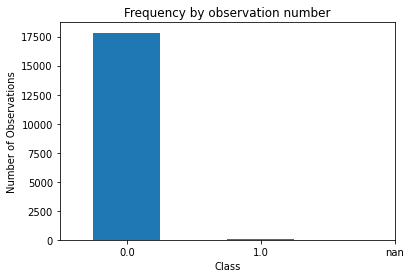

In [ ]:
#Visualizing the imbalanced dataset
count_classes = pd.value_counts(dataset['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(len(dataset['Class'].unique())), dataset.Class.unique())
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");

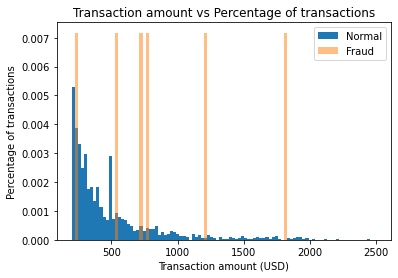

In [ ]:
# Save the normal and fradulent transactions in separate dataframe
normal_dataset = dataset[dataset.Class == 0]
fraud_dataset = dataset[dataset.Class == 1]
#Visualize transactionamounts for normal and fraudulent transactions
bins = np.linspace(200, 2500, 100)
plt.hist(normal_dataset.Amount, bins=bins, alpha=1, density=True, label='Normal')
plt.hist(fraud_dataset.Amount, bins=bins, alpha=0.5, density=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Transaction amount vs Percentage of transactions")
plt.xlabel("Transaction amount (USD)")
plt.ylabel("Percentage of transactions");
plt.show()

In [ ]:
'''Time and Amount are the columns that are not scaled, so applying StandardScaler to only Amount and Time columns.
Normalizing the values between 0 and 1 did not work great for the dataset.'''

'Time and Amount are the columns that are not scaled, so applying StandardScaler to only Amount and Time columns. \nNormalizing the values between 0 and 1 did not work great for the dataset.'

In [ ]:
sc=StandardScaler()
dataset['Time'] = sc.fit_transform(dataset['Time'].values.reshape(-1, 1))
dataset['Amount'] = sc.fit_transform(dataset['Amount'].values.reshape(-1, 1))

In [ ]:
'''The last column in the dataset is our target variable.'''

raw_data = dataset.values
# The last element contains if the transaction is normal which is represented by a 0 and if fraud then 1
labels = raw_data[:, -1]
# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=2021
)

In [ ]:
'''Normalize the data to have a value between 0 and 1'''

min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)
train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)
train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [ ]:
'''Use only normal transactions to train the Autoencoder.

Normal data has a value of 0 in the target variable. Using the target variable to create a normal and fraud dataset.'''

train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

#creating normal and fraud datasets

normal_train_data = train_data[~train_labels]
normal_test_data = test_data[~test_labels]
fraud_train_data = train_data[train_labels]
fraud_test_data = test_data[test_labels]
print(" No. of records in Fraud Train Data=",len(fraud_train_data))
print(" No. of records in Normal Train data=",len(normal_train_data))
print(" No. of records in Fraud Test Data=",len(fraud_test_data))
print(" No. of records in Normal Test data=",len(normal_test_data))

 No. of records in Fraud Train Data= 70
 No. of records in Normal Train data= 14264
 No. of records in Fraud Test Data= 12
 No. of records in Normal Test data= 3572


In [ ]:
nb_epoch = 50
batch_size = 64
input_dim = normal_train_data.shape[1] #num of columns, 30
encoding_dim = 14
hidden_dim_1 = int(encoding_dim / 2) #
hidden_dim_2=4
learning_rate = 1e-7

In [ ]:
#input Layer
input_layer = tf.keras.layers.Input(shape=(input_dim, ))

#Encoder
encoder = tf.keras.layers.Dense(encoding_dim, activation="tanh",
                        activity_regularizer=tf.keras.regularizers.l2(learning_rate))(input_layer)
encoder=tf.keras.layers.Dropout(0.2)(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_2, activation=tf.nn.leaky_relu)(encoder)

# Decoder
decoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
decoder=tf.keras.layers.Dropout(0.2)(decoder)
decoder = tf.keras.layers.Dense(encoding_dim, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(input_dim, activation='tanh')(decoder)

#Autoencoder
autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense (Dense)               (None, 14)                434       
                                                                 
 dropout (Dropout)           (None, 14)                0         
                                                                 
 dense_1 (Dense)             (None, 7)                 105       
                                                                 
 dense_2 (Dense)             (None, 4)                 32        
                                                                 
 dense_3 (Dense)             (None, 7)                 35        
                                                                 
 dropout_1 (Dropout)         (None, 7)                 0     

In [ ]:
"""Define the callbacks for checkpoints and early stopping"""

cp = tf.keras.callbacks.ModelCheckpoint(filepath="autoencoder_fraud.h5",
                               mode='min', monitor='val_loss', verbose=2, save_best_only=True)
# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True)

In [ ]:
#Compile the Autoencoder

autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

In [ ]:
#Train the Autoencoder

history = autoencoder.fit(normal_train_data, normal_train_data,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(test_data, test_data),
                    verbose=1,
                    callbacks=[cp, early_stop]
                    ).history


Epoch 1/50
204/223 [==========================>...] - ETA: 0s - loss: nan - accuracy: 1.0000
Epoch 1: val_loss did not improve from inf
223/223 [==============================] - 2s 5ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 2/50
216/223 [============================>.] - ETA: 0s - loss: nan - accuracy: 1.0000
Epoch 2: val_loss did not improve from inf
223/223 [==============================] - 1s 3ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 3/50
210/223 [===========================>..] - ETA: 0s - loss: nan - accuracy: 1.0000
Epoch 3: val_loss did not improve from inf
223/223 [==============================] - 1s 3ms/step - loss: nan - accuracy: 1.0000 - val_loss: nan - val_accuracy: 1.0000
Epoch 4/50
204/223 [==========================>...] - ETA: 0s - loss: nan - accuracy: 1.0000
Epoch 4: val_loss did not improve from inf
223/223 [==============================] - 1s 3ms/step - loss: nan - accuracy: 1.

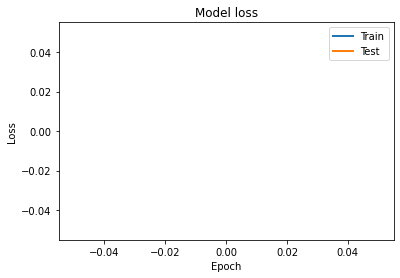

In [ ]:
#Plot training and test loss

plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [ ]:
"""Detect Anomalies on test data

Anomalies are data points where the reconstruction loss is higher

To calculate the reconstruction loss on test data,
predict the test data and calculate the mean square error between the test data and the reconstructed test data."""

test_x_predictions = autoencoder.predict(test_data)
mse = np.mean(np.power(test_data - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_labels})

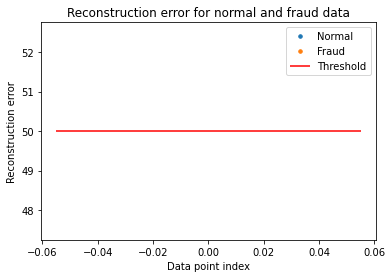

In [ ]:
#Plotting the test data points and their respective reconstruction error sets a threshold value to visualize
#if the threshold value needs to be adjusted.

threshold_fixed = 50
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and fraud data")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

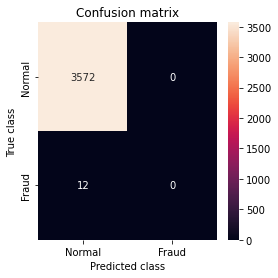

 Accuracy:  0.9966517857142857
 Recall:  0.0
 Precision:  0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
'''Detect anomalies as points where the reconstruction loss is greater than a fixed threshold.
Here we see that a value of 52 for the threshold will be good.

Evaluating the performance of the anomaly detection'''

threshold_fixed =52
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
error_df['pred'] =pred_y
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
# print Accuracy, precision and recall
print(" Accuracy: ",accuracy_score(error_df['True_class'], error_df['pred']))
print(" Recall: ",recall_score(error_df['True_class'], error_df['pred']))
print(" Precision: ",precision_score(error_df['True_class'], error_df['pred']))

In [ ]:
'''As our dataset is highly imbalanced, we see a high accuracy but a low recall and precision.

Things to further improve precision and recall would add more relevant features,
different architecture for autoencoder, different hyperparameters, or a different algorithm.'''

'As our dataset is highly imbalanced, we see a high accuracy but a low recall and precision.\n\nThings to further improve precision and recall would add more relevant features, \ndifferent architecture for autoencoder, different hyperparameters, or a different algorithm.'

In [ ]:
history

{'loss': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
 'accuracy': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'val_loss': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
 'val_accuracy': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}